In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
train=pd.read_excel('Final_Train.xlsx')
test=pd.read_excel('Final_Test.xlsx')

In [3]:
train.head()

,Qualification,Experience,Rating,Place,Profile,Miscellaneous_Info,Fees
0,"BHMS, MD - Homeopathy",24 years experience,100%,"Kakkanad, Ernakulam",Homeopath,"100% 16 Feedback Kakkanad, Ernakulam",100
1,"BAMS, MD - Ayurveda Medicine",12 years experience,98%,"Whitefield, Bangalore",Ayurveda,"98% 76 Feedback Whitefield, Bangalore",350
2,"MBBS, MS - Otorhinolaryngology",9 years experience,NaN,"Mathikere - BEL, Bangalore",ENT Specialist,NaN,300
3,"BSc - Zoology, BAMS",12 years experience,NaN,"Bannerghatta Road, Bangalore",Ayurveda,"Bannerghatta Road, Bangalore ₹250 Available on...",250
4,BAMS,20 years experience,100%,"Keelkattalai, Chennai",Ayurveda,"100% 4 Feedback Keelkattalai, Chennai",250


In [4]:
train.shape

(5961, 7)

We have 5961 rows and 7 columns in our training dataset.

In [5]:
train.isnull().sum()

Qualification            0
Experience               0
Rating                3302
Place                   25
Profile                  0
Miscellaneous_Info    2620
Fees                     0
dtype: int64

We have missing values in rating, place and miscellaneous_info column in training dataset.

In [6]:
train.dtypes

Qualification         object
Experience            object
Rating                object
Place                 object
Profile               object
Miscellaneous_Info    object
Fees                   int64
dtype: object

All the columns are object type except Fees which is our target variable.

In [7]:
train.duplicated().sum()

40

We have 40 duplicate rows in our training dataset. So, we will drop those rows.

In [8]:
train.drop_duplicates(inplace=True)

### EDA for Training Dataset:

We will extract the numerical part of experience column and city part of the place column

In [9]:
train['Experience'] = train['Experience'].str.split().str[0].astype('int64')
train['Place'] = train['Place'].str.split(pat=',').str[1]

Replacing the null values with 'Other' value in Place column

In [10]:
train['Place'].fillna('Other',inplace=True)

In [11]:
train.head()

,Qualification,Experience,Rating,Place,Profile,Miscellaneous_Info,Fees
0,"BHMS, MD - Homeopathy",24,100%,Ernakulam,Homeopath,"100% 16 Feedback Kakkanad, Ernakulam",100
1,"BAMS, MD - Ayurveda Medicine",12,98%,Bangalore,Ayurveda,"98% 76 Feedback Whitefield, Bangalore",350
2,"MBBS, MS - Otorhinolaryngology",9,NaN,Bangalore,ENT Specialist,NaN,300
3,"BSc - Zoology, BAMS",12,NaN,Bangalore,Ayurveda,"Bannerghatta Road, Bangalore ₹250 Available on...",250
4,BAMS,20,100%,Chennai,Ayurveda,"100% 4 Feedback Keelkattalai, Chennai",250


(array([0, 1, 2, 3, 4, 5]),
 [Text(0, 0, 'Homeopath'),
  Text(1, 0, 'Ayurveda'),
  Text(2, 0, 'ENT Specialist'),
  Text(3, 0, 'Dentist'),
  Text(4, 0, 'General Medicine'),
  Text(5, 0, 'Dermatologists')])

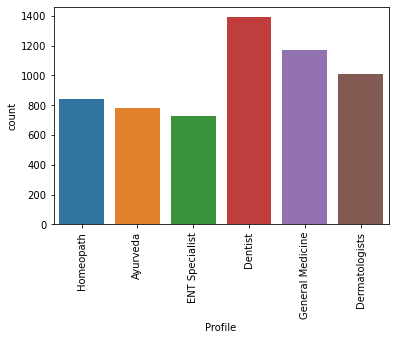

In [12]:
sns.countplot(train['Profile'])
plt.xticks(rotation=90)

Majority of doctors are Dentist,GM and Dermat in our dataset.

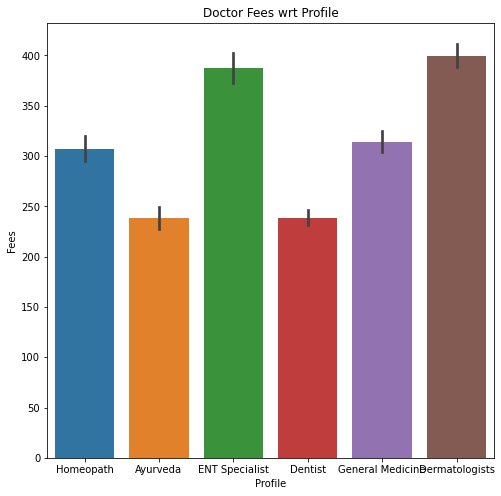

In [13]:
plt.figure(figsize=(8,8))
sns.barplot(x='Profile',y='Fees',data=train)
plt.title("Doctor Fees wrt Profile")
plt.show()

Dermatologists and ENT Specialist charges highest fees while Ayurveda and Dentist charges lowest.

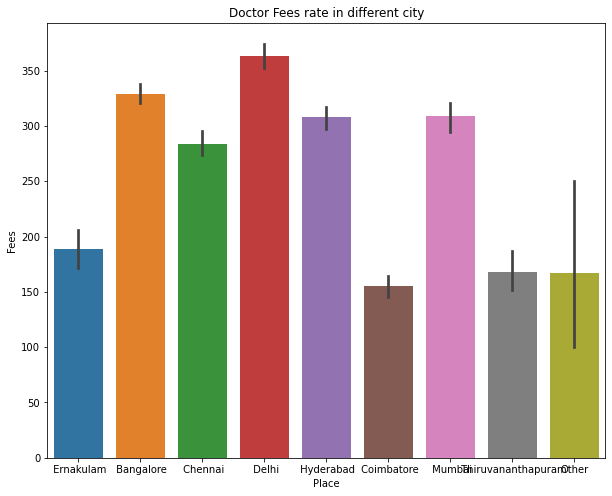

In [14]:
plt.figure(figsize=(10,8))
sns.barplot(x='Place',y='Fees',data=train)
plt.title("Doctor Fees rate in different city")
plt.show()

Fees in the metro cities is higher than other cities.

In [16]:
bins = [0, 10, 20, 30, 40, 50, 60,70]
train['ExperienceBinned'] = pd.cut(train['Experience'], bins)
train[["ExperienceBinned", "Fees"]].groupby(['ExperienceBinned']).mean()

,Fees
ExperienceBinned,
"(0, 10]",294.330971
"(10, 20]",321.017179
"(20, 30]",334.886598
"(30, 40]",315.611702
"(40, 50]",227.479339
"(50, 60]",220.588235
"(60, 70]",100.000000


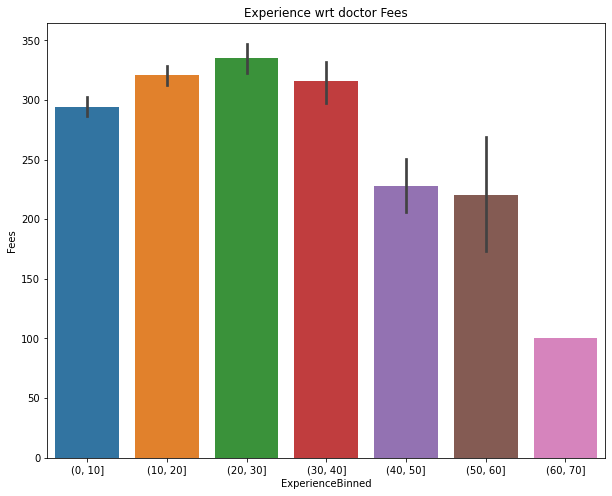

In [17]:
plt.figure(figsize=(10,8))
ax = sns.barplot(x='ExperienceBinned',y='Fees',data=train)
ax.set_title("Experience wrt doctor Fees")
plt.show()

Doctors who have experience between 20 to years charges the highest fees. With increase in experience after 30 years, ees gradually decreases.

Replacing the null values in rating column with -99% and extracting the numerical part of the rating.

In [18]:
train['Rating'].fillna('-99%',inplace=True)

In [19]:
train['Rating'] = train['Rating'].str.split('%').str[0].astype('int64')

In [20]:
train['Rating']

0       100
1        98
2       -99
3       -99
4       100
       ... 
5956     98
5957    -99
5958     97
5959     90
5960    100
Name: Rating, Length: 5921, dtype: int64

Making the bins for rating and labeling them as integers

In [21]:
bins = [-99,0,10,20,30,40,50,60,70,80,90,100]
labels = [i for i in range(11)]
train['Rating'] = pd.cut(train['Rating'], bins=bins, labels=labels, include_lowest=True)

In [22]:
train['Rating'].value_counts()

0     3262
10    2222
9      280
8       98
7       32
6       19
4        4
5        3
1        1
3        0
2        0
Name: Rating, dtype: int64

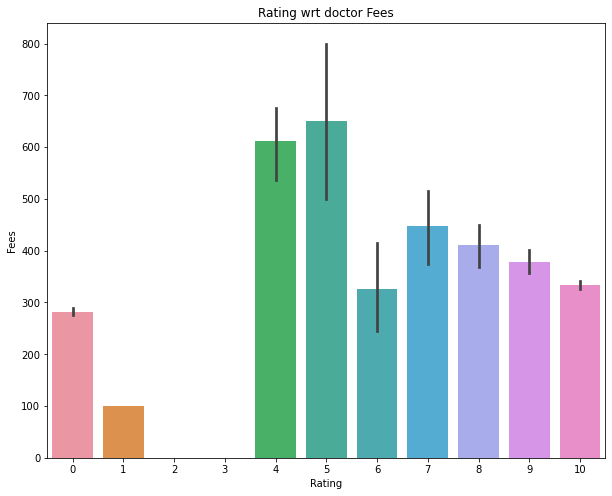

In [26]:
plt.figure(figsize=(10,8))
ax = sns.barplot(x='Rating',y='Fees',data=train)
ax.set_title("Rating wrt doctor Fees")
plt.show()

Doctors with rating more than 4 charge high fees.

In [27]:
train['Qualification'].nunique()

1420

There are 1420 unique qualifications which is quite irrelevant. We will try to extract useful qualifications from them.

In [28]:
# Extract relevant qualification
# Making dictionary of qualification with its counts
train["Qualification"]=train["Qualification"].str.split(",")
Qualification ={}
for x in train["Qualification"].values:
    for each in x:
        each = each.strip()
        if each in Qualification:
            Qualification[each]+=1
        else:
            Qualification[each]=1
            
print(Qualification)

{'BHMS': 746, 'MD - Homeopathy': 180, 'BAMS': 760, 'MD - Ayurveda Medicine': 137, 'MBBS': 2804, 'MS - Otorhinolaryngology': 103, 'BSc - Zoology': 3, 'BDS': 1357, 'MD - General Medicine': 284, 'BSc': 3, 'MS': 2, 'DNB - ENT': 111, 'MDS': 82, 'MDS - Oral & Maxillofacial Surgery': 104, 'Diploma in Otorhinolaryngology (DLO)': 250, 'MF- Homeopathy': 5, 'MS - ENT': 411, 'DNB': 58, 'Fellowship of College of General Practice (FCGP)': 13, 'DDVL': 161, 'IBCLC (USA)': 1, 'Post Graduate Diploma in Diabetology (PGDD)': 53, 'Diploma in Dermatology': 67, 'Fellowship in Aesthetic Medicine': 23, 'DM - Neurology': 6, 'MD - Pediatrics': 13, 'Fellowship in Cleft Lip and Craniofacial Surgery': 1, 'Diploma in Cosmetology': 3, 'AFIH': 4, 'MDS - Prosthodontist And Crown Bridge': 45, 'M. D. Hom. (Practice of Medicine)': 2, 'Diploma in Emergency Medicine': 8, 'Diploma in Counselling Skills': 2, 'DHMS (Diploma in Homeopathic Medicine and Surgery)': 47, 'MD - Dermatology': 606, 'Venereology & Leprosy': 297, 'MDS -

In [29]:
#Extracting top 10 qualifications
most_qual = sorted(Qualification.items(),key=lambda x:x[1],reverse=True)[:10]
final_qual = []
for qual in most_qual:
    final_qual.append(qual[0])
    
print(final_qual)

['MBBS', 'BDS', 'BAMS', 'BHMS', 'MD - Dermatology', 'MS - ENT', 'Venereology & Leprosy', 'MD - General Medicine', 'Diploma in Otorhinolaryngology (DLO)', 'MD - Homeopathy']


In [30]:
#Encode extracted top 10 qualification into train dataset
for qual in final_qual:
    train[qual] = 0

for x,y in zip(train['Qualification'].values, np.array([i for i in range(len(train))])):
    for q in x:
        q = q.strip()
        if q in final_qual:
            train[q][y] = 1

In [31]:
train.head()

,Qualification,Experience,Rating,Place,Profile,Miscellaneous_Info,Fees,ExperienceBinned,MBBS,BDS,BAMS,BHMS,MD - Dermatology,MS - ENT,Venereology & Leprosy,MD - General Medicine,Diploma in Otorhinolaryngology (DLO),MD - Homeopathy
0,"[BHMS, MD - Homeopathy]",24,10,Ernakulam,Homeopath,"100% 16 Feedback Kakkanad, Ernakulam",100,"(20, 30]",0,0,0,1,0,0,0,0,0,1
1,"[BAMS, MD - Ayurveda Medicine]",12,10,Bangalore,Ayurveda,"98% 76 Feedback Whitefield, Bangalore",350,"(10, 20]",0,0,1,0,0,0,0,0,0,0
2,"[MBBS, MS - Otorhinolaryngology]",9,0,Bangalore,ENT Specialist,NaN,300,"(0, 10]",1,0,0,0,0,0,0,0,0,0
3,"[BSc - Zoology, BAMS]",12,0,Bangalore,Ayurveda,"Bannerghatta Road, Bangalore ₹250 Available on...",250,"(10, 20]",0,0,1,0,0,0,0,0,0,0
4,[BAMS],20,10,Chennai,Ayurveda,"100% 4 Feedback Keelkattalai, Chennai",250,"(10, 20]",0,0,1,0,0,0,0,0,0,0


Now, we have label encoded qualifications in our dataset. So, we can remove Qualification column from our dataset.

In [34]:
train.drop('Qualification',axis=1,inplace=True)

One-Hot Encoding for categorical variable.

In [35]:
train = pd.get_dummies(train,columns=['Place','Profile'])

In [36]:
#Dropping the miscellineous column
train.drop('Miscellaneous_Info',axis=1,inplace=True)

In [67]:
#Dropping Experience binned column
train.drop('ExperienceBinned',axis=1,inplace=True)

In [68]:
train.head()

,Experience,Rating,Fees,MBBS,BDS,BAMS,BHMS,MD - Dermatology,MS - ENT,Venereology & Leprosy,...,Place_ Hyderabad,Place_ Mumbai,Place_ Thiruvananthapuram,Place_Other,Profile_Ayurveda,Profile_Dentist,Profile_Dermatologists,Profile_ENT Specialist,Profile_General Medicine,Profile_Homeopath
0,24,10,100,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,12,10,350,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,9,0,300,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,12,0,250,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,20,10,250,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


### EDA for Test DataSet

In [41]:
test.shape

(1987, 6)

There are 1987 rows and 6 columns in our test Dataset.

In [38]:
test.isnull().sum()

Qualification            0
Experience               0
Rating                1090
Place                    6
Profile                  0
Miscellaneous_Info     834
dtype: int64

There are missing valuesin Rating,Place and Miscellaneous info

In [42]:
test.dtypes

Qualification         object
Experience            object
Rating                object
Place                 object
Profile               object
Miscellaneous_Info    object
dtype: object

All the columns are categorical data

In [43]:
test.head()

,Qualification,Experience,Rating,Place,Profile,Miscellaneous_Info
0,MBBS,35 years experience,NaN,"Ghatkopar East, Mumbai",General Medicine,NaN
1,"MBBS, Diploma in Otorhinolaryngology (DLO)",31 years experience,NaN,"West Marredpally, Hyderabad",ENT Specialist,NaN
2,"MBBS, DDVL",40 years experience,70%,"KK Nagar, Chennai",Dermatologists,"70% 4 Feedback KK Nagar, Chennai"
3,BAMS,0 years experience,NaN,"New Ashok Nagar, Delhi",Ayurveda,NaN
4,"BDS, MDS - Conservative Dentistry & Endodontics",16 years experience,100%,"Kanakpura Road, Bangalore",Dentist,General Dentistry Conservative Dentistry Cosme...


We will extract the numerical part of experience column and city part of the place column

In [44]:
test['Experience'] = test['Experience'].str.split().str[0].astype('int64')
test['Place'] = test['Place'].str.split(pat=',').str[1]

Replacing null values in Place column with 'Other'

In [45]:
test['Place'].fillna('Other',inplace=True)

(array([0, 1, 2, 3, 4, 5]),
 [Text(0, 0, 'General Medicine'),
  Text(1, 0, 'ENT Specialist'),
  Text(2, 0, 'Dermatologists'),
  Text(3, 0, 'Ayurveda'),
  Text(4, 0, 'Dentist'),
  Text(5, 0, 'Homeopath')])

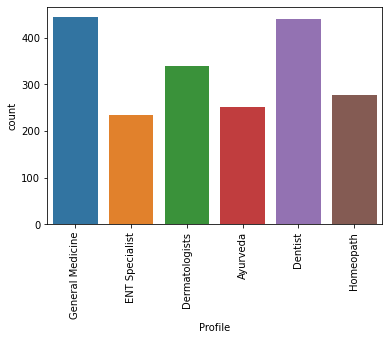

In [48]:
sns.countplot(test['Profile'])
plt.xticks(rotation=90)

We have majority of Dentists and GM in our dataset.

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 [Text(0, 0, ' Mumbai'),
  Text(1, 0, ' Hyderabad'),
  Text(2, 0, ' Chennai'),
  Text(3, 0, ' Delhi'),
  Text(4, 0, ' Bangalore'),
  Text(5, 0, ' Coimbatore'),
  Text(6, 0, ' Thiruvananthapuram'),
  Text(7, 0, ' Ernakulam'),
  Text(8, 0, 'Other')])

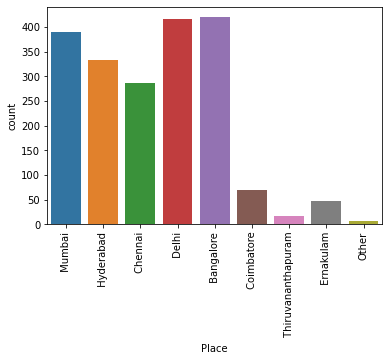

In [49]:
sns.countplot(test['Place'])
plt.xticks(rotation=90)

Majority of doctors are living in metro cities.

Replacing the null values in rating column with -99% and extracting the numerical part of the rating.

In [51]:
test['Rating'].fillna('-99%',inplace=True)

In [52]:
test['Rating'] = test['Rating'].str.split('%').str[0].astype('int64')

In [53]:
test['Rating']

0       -99
1       -99
2        70
3       -99
4       100
       ... 
1982    -99
1983    -99
1984    -99
1985     98
1986    -99
Name: Rating, Length: 1987, dtype: int64

Making bins for ratings and labelling them as integers

In [54]:
bins = [-99,0,10,20,30,40,50,60,70,80,90,100]
labels = [i for i in range(11)]
test['Rating'] = pd.cut(test['Rating'], bins=bins, labels=labels, include_lowest=True)

In [55]:
test['Rating'].value_counts()

0     1090
10     739
9      108
8       27
7       14
6        9
5        0
4        0
3        0
2        0
1        0
Name: Rating, dtype: int64

In [56]:
#Making dictionary of qualification with its counts
data = pd.read_excel('Final_Train.xlsx')
data['Qualification'] = data['Qualification'].str.split(",")
Qualification = {}
for x in data['Qualification']:
    for each in x:
        each = each.strip()
        if each in Qualification:
            Qualification[each] += 1
        else:
            Qualification[each] = 1

In [57]:
# finding out the top 10 Qualification
most_qual = sorted(Qualification.items(), key=lambda x:x[1], reverse=True)[:10]
final_qual = []
for qual in most_qual:
    final_qual.append(qual[0])

In [58]:
#encode the top 10 qualification in test dataset
for title in final_qual:
    test[title] = 0

for x,y in zip(test['Qualification'].values, np.array([i for i in range(len(test))])):
    for q in x:
        q = q.strip()
        if q in final_qual:
            test[q][y] = 1

Now, we have label encoded qualifications in our dataset. So, we can remove Qualification column from our dataset.

In [59]:
#drop Qualification after getting top 10 qual.
test.drop('Qualification',axis=1,inplace=True)

In [60]:
test.head()

,Experience,Rating,Place,Profile,Miscellaneous_Info,MBBS,BDS,BAMS,BHMS,MD - Dermatology,MS - ENT,Venereology & Leprosy,MD - General Medicine,Diploma in Otorhinolaryngology (DLO),MD - Homeopathy
0,35,0,Mumbai,General Medicine,NaN,0,0,0,0,0,0,0,0,0,0
1,31,0,Hyderabad,ENT Specialist,NaN,0,0,0,0,0,0,0,0,0,0
2,40,7,Chennai,Dermatologists,"70% 4 Feedback KK Nagar, Chennai",0,0,0,0,0,0,0,0,0,0
3,0,0,Delhi,Ayurveda,NaN,0,0,0,0,0,0,0,0,0,0
4,16,10,Bangalore,Dentist,General Dentistry Conservative Dentistry Cosme...,0,0,0,0,0,0,0,0,0,0


In [61]:
#One-Hot Encoding for categorical data
test = pd.get_dummies(test,columns=['Place','Profile'])

In [62]:
#Dropping miscellaneous column as it contains only redundant information
test.drop('Miscellaneous_Info',axis=1,inplace=True)

In [63]:
test.head()

,Experience,Rating,MBBS,BDS,BAMS,BHMS,MD - Dermatology,MS - ENT,Venereology & Leprosy,MD - General Medicine,...,Place_ Hyderabad,Place_ Mumbai,Place_ Thiruvananthapuram,Place_Other,Profile_Ayurveda,Profile_Dentist,Profile_Dermatologists,Profile_ENT Specialist,Profile_General Medicine,Profile_Homeopath
0,35,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
1,31,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
2,40,7,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,16,10,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [69]:
#separating x and y columns for model evaluation
x = train.drop('Fees',axis=1)
y = train['Fees']

In [70]:
#lets bring all features to a common scale
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X = sc.fit_transform(x)

In [71]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor 
from sklearn.neighbors import KNeighborsRegressor 
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score

### Finding the best Random State

In [72]:
from sklearn.linear_model import LinearRegression

from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error
maxAccu=0
maxRS=0
for i in range(1,200):
    x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=.2,random_state=i)
    lg=LinearRegression()
    lg.fit(x_train,y_train)
    predrf=lg.predict(x_test)
    acc=r2_score(y_test,predrf)
    if acc>maxAccu:
        maxAccu=acc
        maxRS=i
print("Best accuracy is ",maxAccu," on Random_state ",maxRS) 

Best accuracy is  0.21567139955903902  on Random_state  5


### Model Evaluation

In [73]:
# train-test split
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=maxRS)

In [74]:
model=[DecisionTreeRegressor(),SVR(gamma='scale'),KNeighborsRegressor(),RandomForestRegressor(),LinearRegression()]

for m in model:
    m.fit(x_train,y_train)
    m.score(x_train,y_train)
    predm=m.predict(x_test)
    print(m)
    print(m.score(x_train,y_train))
    print("error: ")
    print("Mean absolute error: ",mean_absolute_error(y_test,predm))
    print("Mean squared error: ",mean_squared_error(y_test,predm))
    print("Root mean squared error: ",np.sqrt(mean_squared_error(y_test,predm)))
    print("\n\n")

DecisionTreeRegressor()
0.8842964944352069
error: 
Mean absolute error:  172.39085794655418
Mean squared error:  55793.47072198781
Root mean squared error:  236.20641549709825



SVR()
0.06222484000082962
error: 
Mean absolute error:  150.59941808749087
Mean squared error:  36163.41054973948
Root mean squared error:  190.1667966542516



KNeighborsRegressor()
0.3486449422049349
error: 
Mean absolute error:  142.7304641350211
Mean squared error:  34321.09549367088
Root mean squared error:  185.25953549998684



RandomForestRegressor()
0.7839353517066191
error: 
Mean absolute error:  143.39810545010545
Mean squared error:  35365.49010640065
Root mean squared error:  188.05714585306416



LinearRegression()
0.15907024292888639
error: 
Mean absolute error:  137.70100979391177
Mean squared error:  29906.441854763812
Root mean squared error:  172.93479075872446





### Performing Cross-Validation

In [76]:
from sklearn.model_selection import cross_val_score
dtscore=cross_val_score(DecisionTreeRegressor(),X,y,cv=5,scoring='r2')
dtc=dtscore.mean()
print('Cross val score:',dtc*100)

Cross val score: -55.63860139724077


In [82]:
svrscore=cross_val_score(SVR(),X,y,cv=5,scoring='r2')
svc=svrscore.mean()
print('Cross val score:',svc*100)

Cross val score: 6.462523847371529


In [83]:
knnscore=cross_val_score(KNeighborsRegressor(),X,y,cv=5,scoring='r2')
knn=knnscore.mean()
print('Cross val score:',knn*100)

Cross val score: 4.652771597572309


In [84]:
rfscore=cross_val_score(RandomForestRegressor(),X,y,cv=5,scoring='r2')
rfc=rfscore.mean()
print('Cross val score:',rfc*100)

Cross val score: 0.7126674637861052


In [85]:
lrscore=cross_val_score(LinearRegression(),X,y,cv=5,scoring='r2')
lrc=lrscore.mean()
print('Cross val score:',lrc*100)

Cross val score: 16.363676626308564


### Regularization

In [86]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso,Ridge
parameters={'alpha':[.0001,.001,.01,.1,1,10],'random_state':list(range(0,10))}
ls=Ridge()
clf=GridSearchCV(ls,parameters)
clf.fit(x_train,y_train)
print(clf.best_params_)

{'alpha': 10, 'random_state': 0}


In [87]:
ls=Ridge(alpha=10,random_state=0)
ls.fit(x_train,y_train)
ls.score(x_train,y_train)
predls=ls.predict(x_test)
lss=r2_score(y_test,predls)
print('r2_score:', lss)
print("error: ")
print("Mean absolute error: ",mean_absolute_error(y_test,predls))
print("Mean squared error: ",mean_squared_error(y_test,predls))
print("Root mean squared error: ",np.sqrt(mean_squared_error(y_test,predls)))

r2_score: 0.21570223474285866
error: 
Mean absolute error:  137.6854408817347
Mean squared error:  29905.266109506705
Root mean squared error:  172.93139133629472


### HyperParameter Tuning

In [88]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [91]:
grid = dict(C=[0.1,1,10], kernel=['linear','poly','rbf'], gamma=['scale','auto'])
svr = RandomizedSearchCV(SVR(), param_distributions= grid, scoring='r2', cv=5, random_state=42, n_iter=100, verbose=1, n_jobs=-1)

In [92]:
svr.fit(x_train,y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


RandomizedSearchCV(cv=5, estimator=SVR(), n_iter=100, n_jobs=-1,
                   param_distributions={'C': [0.1, 1, 10],
                                        'gamma': ['scale', 'auto'],
                                        'kernel': ['linear', 'poly', 'rbf']},
                   random_state=42, scoring='r2', verbose=1)

In [93]:
print("best_params:\n",svr.best_params_)

best_params:
 {'kernel': 'rbf', 'gamma': 'scale', 'C': 10}


In [94]:
sv=SVR(kernel='rbf',gamma='scale',C=10)
sv.fit(x_train,y_train)
sv.score(x_train,y_train)
predls=sv.predict(x_test)
svr=r2_score(y_test,predls)
print('r2_score:', svr)
print("error: ")
print("Mean absolute error: ",mean_absolute_error(y_test,predls))
print("Mean squared error: ",mean_squared_error(y_test,predls))
print("Root mean squared error: ",np.sqrt(mean_squared_error(y_test,predls)))

r2_score: 0.17638745781963727
error: 
Mean absolute error:  136.80678718498675
Mean squared error:  31404.338168623635
Root mean squared error:  177.21269189486299


In [95]:
rf = RandomForestRegressor()

In [96]:
n_estimators = [int(x) for x in np.linspace(start=150,stop=1000,num=6)]
max_depth = [int(x) for x in np.linspace(start=6,stop=30,num=5)]
min_samples_split = [2,7,10]
min_samples_leaf = [2,5]
max_features=['sqrt','auto']
random_grid = {'n_estimators':n_estimators,
               'max_depth':max_depth,
               'min_samples_split':min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'max_features':max_features,
              }

In [98]:
rfm = RandomizedSearchCV(rf, param_distributions=random_grid, scoring='r2', cv=5, n_iter=100, random_state=42, verbose=1, n_jobs=-1)

rfm.fit(x_train,y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'max_depth': [6, 12, 18, 24, 30],
                                        'max_features': ['sqrt', 'auto'],
                                        'min_samples_leaf': [2, 5],
                                        'min_samples_split': [2, 7, 10],
                                        'n_estimators': [150, 320, 490, 660,
                                                         830, 1000]},
                   random_state=42, scoring='r2', verbose=1)

In [101]:
print("best_params:\n",rfm.best_params_)

best_params:
 {'n_estimators': 150, 'min_samples_split': 2, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'max_depth': 12}


In [102]:
rf=RandomForestRegressor(min_samples_split=2,min_samples_leaf=5,max_features="sqrt",n_estimators=150,max_depth=12)
rf.fit(x_train,y_train)
rf.score(x_train,y_train)
pred_decision=rf.predict(x_test)
rfs=r2_score(y_test,pred_decision)
print('R2 Score:',rfs*100)
print("error: ")
print("Mean absolute error: ",mean_absolute_error(y_test,pred_decision))
print("Mean squared error: ",mean_squared_error(y_test,pred_decision))
print("Root mean squared error: ",np.sqrt(mean_squared_error(y_test,pred_decision)))
rfscore=cross_val_score(rf,X,y,cv=5)
rfc=rfscore.mean()
print('Cross val score:',rfc*100)

R2 Score: 23.507875333704074
error: 
Mean absolute error:  135.99946611159348
Mean squared error:  29166.43964524305
Root mean squared error:  170.78184811402835
Cross val score: 18.55811623251138


After performing hyper-parameter tuning, we can see Random Forest Regressor have least MAE, MSE, RMSE. So we will select RF as our best model

### Prediction for Test Data

In [104]:
pred=rf.predict(test)

In [106]:
df=pd.DataFrame(pred)
df.to_csv('fees_submission.csv')

In [107]:
df

,0
0,253.897881
1,295.309545
2,313.113089
3,371.992261
4,283.590679
...,...
1982,307.413557
1983,292.474538
1984,270.683475
1985,283.590679


### Saving the model

In [103]:
import joblib
joblib.dump(rf,'fees.pkl')

['fees.pkl']